In [49]:
import os
import torch
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix


In [50]:
class SubMNIST(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.__load_data(self.root)
        if self.transform:
            self.data = self.transform(self.data)
        if self.target_transform:
            self.label = self.target_transform(self.label)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
        
    def __load_data(self, root):
        tree = os.walk(root)
        next(tree)
        self.data, self.label = [], []
        for dirpath, dirnames, filenames in tree:
            os.chdir(dirpath)
            self.data += [read_image(filename)/255 for filename in filenames]
            self.label += [int(os.path.relpath(dirpath, root))] * len(filenames)

In [51]:
%%time
training_data = SubMNIST(
    '/home/pongthang/Documents/6thSem/deepLearning/assign2/Group_8/train'
)
validation_data = SubMNIST(
    '/home/pongthang/Documents/6thSem/deepLearning/assign2/Group_8/val'
)
test_data = SubMNIST(
    '/home/pongthang/Documents/6thSem/deepLearning/assign2/Group_8/test'
)

CPU times: user 4.73 s, sys: 1.83 s, total: 6.56 s
Wall time: 17.8 s


In [52]:
batch_size = 16
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self,N):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder= nn.Sequential(
            nn.Linear(28*28,N),
            nn.Sigmoid()
        
        )
        self.decoder= nn.Sequential(
            nn.Linear(N,28*28)
        )
        
        self.classifier= nn.Sequential(
            nn.Linear(N, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )
        
    
    def classify(self,X):
        X = self.flatten(X)
        self.encoder[0].weight.requires_grad=False
        encode_cl=self.encoder(X)
        return self.classifier(encode_cl)
        
        
    def forward(self, X):
        X = self.flatten(X)
        encode=self.encoder(X)
        
        return self.decoder(encode)

In [53]:
#Testing and validation
def test(dataloader, model, loss_fn,name,test_type,denoise):
    flat = nn.Flatten()
    error_test=0
    correct_test=0
    total_test=0
    
    with torch.no_grad():
        for batch, (X, z) in enumerate(dataloader):
            
            total_test+=len(X)
            if denoise==True:
                X_noise=torch.clamp(X + F.dropout(torch.rand_like(X), p=0.8), 0, 1)
            else:
                X_noise=X
                
            if test_type=="encoder":
                pred_test = model(X_noise)
                y=flat(X)
                error_test +=loss_fn(pred_test, y).item()
             
            elif test_type=="check_encoder":
                
                pred_test=model.classify(X_noise)
                error_test+=loss_fn(pred_test,z).item()
                correct_test+=(pred_test.argmax(dim=1) == z).sum().item()
            
                #total_test+=len(pred_test)
            else:
                pred_test=model.classify(X_noise)
                error_test+=loss_fn(pred_test,z).item()
                correct_test+=(pred_test.argmax(dim=1) == z).sum().item()
              
                #total_test+=len(pred_test)
            
    
    if test_type=="encoder":
        print(f'The mean square error of {name} is {error_test/len(dataloader):.5f}')
    else:
        print(f'The accuracy of {name} of classifier is {(correct_test/total_test)*100:.2f}%')
        #print(f'The cross entropy error of {name} is {error_test/len(dataloader):.5f}')   
    
    return error_test/len(dataloader)
           
            

In [54]:
#training
def training(dataloader,model,loss_fn,optimizer,valid_dataloader,train_type,denoise):
    flat = nn.Flatten()
    average_valid=[]
    average_error=[]
    e=0
    threshold=1e-4
    present_err=0
    past_err=4*threshold
    count=0
    
    while abs(present_err-past_err)>threshold:
#     for i in range(20):
        count+=1
        e+=1
        print(f'Epochs {e}')
        
        if train_type=="check_encoder" and count==5:
#             print("dshfgkjdsgfdfgdsfj")
            break
        
        error=0
        validation_error=0
        correct=0
        total=0
        total_train=0
        for batch, (X, z) in enumerate(dataloader):
            if denoise==True:
                X_noise=torch.clamp(X + F.dropout(torch.rand_like(X), p=0.8), 0, 1)
            else:
                X_noise=X
            
            if train_type=="encoder":
                pred = model(X_noise)
                y=flat(X)
                loss = loss_fn(pred, y) 
                error+=loss.item()
            elif train_type=="check_encoder":
                pred=model.classify(X_noise)
                loss=loss_fn(pred,z)
                correct+=(pred.argmax(dim=1) == z).sum().item()
                error+=loss.item()
            else:
                pred=model.classify(X_noise)
                loss=loss_fn(pred,z)
                correct+=(pred.argmax(dim=1) == z).sum().item()
                error+=loss.item()
            total += len(X)    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        
        av_error=error/len(dataloader)#total
        average_error.append(av_error)
            
        if train_type=="encoder":
            print(f'The mean square error of training is {av_error:.5f}')
        else:
            print(f'The accuracy of training of classifier is {(correct/total)*100:.2f}%')
                    
        
        if train_type=="check_encoder":
            present_err=100
            past_err=0
        else:
            past_err=present_err
            present_err=av_error
        
        average_valid.append(test(val_dataloader,model,loss_fn,"validation",train_type,denoise))
        print("diff=",abs(present_err-past_err))
   
    return average_error,average_valid, (correct/total)*100
    

In [55]:
class Classifier(nn.Module):
    def __init__(self,N):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder=nn.Sequential(
        
        )
        
        self.hidden_layers = nn.Sequential(
            nn.Linear(N, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )
        
    def classify(self, X):
        X = self.flatten(X)
        self.encoder[0].weight.requires_grad=False
        encode=self.encoder(X)
        
        return self.hidden_layers(encode)
    def encode(self,X):
        X = self.flatten(X)
        return self.encoder(X)
        

In [13]:
loss_fn = nn.MSELoss()
acc_list = []
for x in range(10, 611, 50):
    print('---------------------------------------------------')
    print(f'Nodes = {x}\n')
    adam_model = NeuralNetwork(x) #number of neuron for bottle neck layer 
    optimizer_adam = torch.optim.Adam(adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    avg_error,avg_validation,_=training(train_dataloader,adam_model,loss_fn,
                                  optimizer_adam,val_dataloader,"encoder",denoise=False)
    optimizer_adam = torch.optim.Adam(adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    loss_fn_classifier = nn.CrossEntropyLoss()
    avg_error,avg_validation,acc=training(train_dataloader,adam_model,loss_fn_classifier,optimizer_adam,
                                      val_dataloader,"check_encoder",denoise=False)
    acc_list.append(acc)

---------------------------------------------------
Nodes = 10

Epochs 1
The mean square error of training is 0.06509
The mean square error of validation is 0.04857
diff= 0.06508813745059659
Epochs 2
The mean square error of training is 0.04166
The mean square error of validation is 0.03823
diff= 0.023425333727716227
Epochs 3
The mean square error of training is 0.03571
The mean square error of validation is 0.03442
diff= 0.005952992243692279
Epochs 4
The mean square error of training is 0.03275
The mean square error of validation is 0.03207
diff= 0.002955282010200823
Epochs 5
The mean square error of training is 0.03073
The mean square error of validation is 0.03048
diff= 0.0020203812994858197
Epochs 6
The mean square error of training is 0.02956
The mean square error of validation is 0.02966
diff= 0.001173567673023998
Epochs 7
The mean square error of training is 0.02899
The mean square error of validation is 0.02929
diff= 0.00057387677167825
Epochs 8
The mean square error of trainin

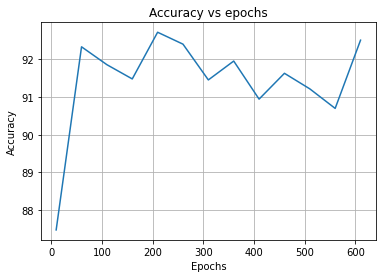

In [14]:
plt.plot(range(10, 611, 10), acc_list)
plt.title('Accuracy vs neurons')
plt.xlabel('neurons')
plt.ylabel('Accuracy')
plt.grid(True)

In [17]:
acc_list

[93.29819938515591,
 92.15634606938956,
 91.32191480017568,
 92.43741765480897,
 90.566534914361,
 91.44488361879665,
 92.39350021958718,
 92.05094422485726,
 91.58541941150636,
 92.05972771190163,
 92.17391304347827]

In [18]:
loss_fn = nn.MSELoss()
acc_list = []
for x in range(160, 210+1, 10):
    print('---------------------------------------------------')
    print(f'Nodes = {x}\n')
    adam_model = NeuralNetwork(x) #number of neuron for bottle neck layer 
    optimizer_adam = torch.optim.Adam(adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    avg_error,avg_validation,_=training(train_dataloader,adam_model,loss_fn,
                                  optimizer_adam,val_dataloader,"encoder",denoise=False)
    optimizer_adam = torch.optim.Adam(adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    loss_fn_classifier = nn.CrossEntropyLoss()
    avg_error,avg_validation,acc=training(train_dataloader,adam_model,loss_fn_classifier,optimizer_adam,
                                      val_dataloader,"check_encoder",denoise=False)
    acc_list.append(acc)

---------------------------------------------------
Nodes = 160

Epochs 1
The mean square error of training is 0.02771
The mean square error of validation is 0.01478
diff= 0.02770808580451844
Epochs 2
The mean square error of training is 0.01115
The mean square error of validation is 0.00905
diff= 0.01656220111279131
Epochs 3
The mean square error of training is 0.00765
The mean square error of validation is 0.00695
diff= 0.003493943320995386
Epochs 4
The mean square error of training is 0.00611
The mean square error of validation is 0.00578
diff= 0.0015462417458968888
Epochs 5
The mean square error of training is 0.00523
The mean square error of validation is 0.00508
diff= 0.0008734472895831156
Epochs 6
The mean square error of training is 0.00464
The mean square error of validation is 0.00463
diff= 0.0005881067050170956
Epochs 7
The mean square error of training is 0.00426
The mean square error of validation is 0.00430
diff= 0.00038634122707723994
Epochs 8
The mean square error of tr

In [21]:
acc_list


[89.60913482652613,
 92.29688186209926,
 92.14756258234519,
 90.46113306982872,
 90.42599912165129,
 91.99824330259113]

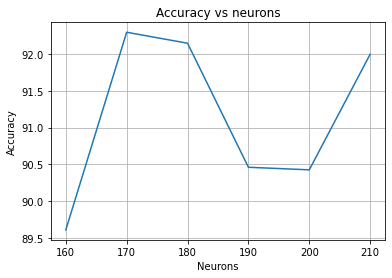

In [20]:
plt.plot(range(160, 210+1, 10), acc_list)
plt.title('Accuracy vs neurons')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.grid(True)

In [ ]:
#Train encoder
adam_model = NeuralNetwork(32) #number of neuron for bottle neck layer 
optimizer_adam = torch.optim.Adam(adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn = nn.MSELoss()

#Train type = "encoder" or "check_encoder" or "classifier"

avg_error,avg_validation=training(train_dataloader,adam_model,loss_fn,
                                  optimizer_adam,val_dataloader,"encoder",denoise=False)
#Plot the error vs epochs
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.title("Autoencoder")
plt.xlabel("Number of epochs")
plt.ylabel("Mean Squared error")
plt.legend()
plt.show()
# #Testing of encoder
# test(test_dataloader, adam_model, loss_fn,"testing","encoder")

# #Run this to check encoder
optimizer_adam = torch.optim.Adam(adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn_classifier = nn.CrossEntropyLoss()
avg_error,avg_validation=training(train_dataloader,adam_model,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"check_encoder",denoise=False)
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.title("Classifier to check efficiency of encoder ")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy error")
plt.legend()
plt.show()


In [ ]:
#Train encoder
adam_model_64 = NeuralNetwork(64) #number of neuron for bottle neck layer 
optimizer_adam = torch.optim.Adam(adam_model_64.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn = nn.MSELoss()

#Train type = "encoder" or "check_encoder" or "classifier"

avg_error,avg_validation=training(train_dataloader,adam_model_64,loss_fn,
                                  optimizer_adam,val_dataloader,"encoder",denoise=False)
#Plot the error vs epochs
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.title("Autoencoder")
plt.xlabel("Number of epochs")
plt.ylabel("Mean Squared error")
plt.legend()
plt.show()
# #Testing of encoder
# test(test_dataloader, adam_model, loss_fn,"testing","encoder")

# #Run this by changing the parameters of the Neural Networks until you find the satisfaction
optimizer_adam = torch.optim.Adam(adam_model_64.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn_classifier = nn.CrossEntropyLoss()
avg_error,avg_validation=training(train_dataloader,adam_model_64,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"check_encoder",denoise=False)
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.title("Classifier to check efficiency of encoder ")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy error")
plt.legend()
plt.show()


In [ ]:
#Train encoder
adam_model_100 = NeuralNetwork(100) #number of neuron for bottle neck layer 
optimizer_adam = torch.optim.Adam(adam_model_100.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn = nn.MSELoss()

#Train type = "encoder" or "check_encoder" or "classifier"

avg_error,avg_validation=training(train_dataloader,adam_model_100,loss_fn,
                                  optimizer_adam,val_dataloader,"encoder",denoise=False)
#Plot the error vs epochs
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.xlabel("Number of epochs")
plt.ylabel("Mean Squared error")
plt.legend()
plt.show()
# #Testing of encoder
# test(test_dataloader, adam_model_100, loss_fn,"testing","encoder")

# #Checking encoder
optimizer_adam = torch.optim.Adam(adam_model_100.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn_classifier = nn.CrossEntropyLoss()
avg_error,avg_validation=training(train_dataloader,adam_model_100,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"check_encoder",denoise=False)
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.title("Classifier to check efficiency of encoder ")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy error")
plt.legend()
plt.show()


In [ ]:
#Train encoder
adam_model_80 = NeuralNetwork(5) #number of neuron for bottle neck layer 
optimizer_adam = torch.optim.Adam(adam_model_80.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn = nn.MSELoss()

#Train type = "encoder" or "check_encoder" or "classifier"

avg_error,avg_validation=training(train_dataloader,adam_model_80,loss_fn,
                                  optimizer_adam,val_dataloader,"encoder",denoise=False)
#Plot the error vs epochs
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.xlabel("Number of epochs")
plt.ylabel("Mean Squared error")
plt.legend()
plt.show()
# #Testing of encoder
# test(test_dataloader, adam_model_80, loss_fn,"testing","encoder")

# #Run this by changing the parameters of the Neural Networks until you find the satisfaction
optimizer_adam = torch.optim.Adam(adam_model_80.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn_classifier = nn.CrossEntropyLoss()
avg_error,avg_validation=training(train_dataloader,adam_model_80,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"check_encoder",denoise=False)
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.title("Classifier to check efficiency of encoder ")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy error")
plt.legend()
plt.show()


In [ ]:
#Train encoder
denoised_adam_model = NeuralNetwork(64) #number of neuron for bottle neck layer 
optimizer_adam = torch.optim.Adam(denoised_adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn = nn.MSELoss()

#Train type = "encoder" or "check_encoder" or "classifier"

avg_error,avg_validation=training(train_dataloader,denoised_adam_model,loss_fn,
                                  optimizer_adam,val_dataloader,"encoder",denoise=True)
#Plot the error vs epochs
plt.plot(avg_error)
plt.plot(avg_validation)
plt.show()
# #Testing of encoder
# test(test_dataloader, denoised_adam_model, loss_fn,"testing","encoder")

# #Run this by changing the parameters of the Neural Networks until you find the satisfaction


    

In [ ]:
#Test encoder
error_test_en=test(test_dataloader,adam_model,loss_fn,"testing","encoder",denoise=False)

In [ ]:
#Test encoder
error_test_en=test(test_dataloader,denoised_adam_model,loss_fn,"testing","encoder",denoise=True)

In [22]:
def reconst(dataloader, model, loss_fn,name,denoise):
    flat = nn.Flatten()
    y=[]
    pred=[]
    error=0
    with torch.no_grad():
        for batch, (X, z) in enumerate(dataloader):
            if batch==0:
                y=flat(X)
                if denoise==True:
                    X_noise=torch.clamp(X + F.dropout(torch.rand_like(X), p=0.8), 0, 1)
                    y_noise=flat(X_noise)
                    
                    pred = model(X_noise)
                    
                    error += loss_fn(pred, y).item()
                    print(f'The mean square error of {name} is {(error)*100}% when data is denoised')
                    error=0

                    fig = plt.figure(figsize=(8, 8))
                    columns = 4
                    rows = 3
                    for i in range(1,rows*columns+1):
                        img = y_noise[i-1].reshape((28,28))
                        ax=fig.add_subplot(rows, columns, i)
                        plt.imshow(img)
                        ax.get_xaxis().set_ticks([])
                        plt.title("Given Image")
                    plt.show()
                    print()
                    fig = plt.figure(figsize=(8, 8))
                #     columns = 3
                #     rows = 3
                    for i in range(1,rows*columns+1):
                        img = pred[i-1].reshape((28,28))
                        ax=fig.add_subplot(rows, columns, i)
                        ax.get_xaxis().set_ticks([])
                        plt.imshow(img)
                        plt.title("Reconstructed")
                    plt.show()
                else:
                    pass
                
                pred = model(X)
                error += loss_fn(pred, y).item()/len(X)
                break
    print(f'The mean square error of {name} is {error}')
    

    fig = plt.figure(figsize=(10, 8))
    columns = 4
    rows = 2
    for i in range(1,rows*columns+1):
        img = y[i-1].reshape((28,28))
        ax=fig.add_subplot(rows, columns, i)
        plt.imshow(img,cmap='gray')
        ax.get_xaxis().set_ticks([])
        plt.title("Given Image")
    plt.show()
    print()
    fig = plt.figure(figsize=(10, 8))
#     columns = 3
#     rows = 3
    for i in range(1,rows*columns+1):
        img = pred[i-1].reshape((28,28))
        ax=fig.add_subplot(rows, columns, i)
        ax.get_xaxis().set_ticks([])
        plt.imshow(img,cmap='gray')
        plt.title("Reconstructed")
    plt.show()
    
   
    return y,pred
    

In [ ]:
# #Reconstruction
loss_fn = nn.MSELoss()
Y,pred_y=reconst(test_dataloader,adam_model,loss_fn,"reconstruction",denoise=False)

In [ ]:
# #Reconstruction
loss_fn = nn.MSELoss()
Y,pred_y=reconst(test_dataloader,denoised_adam_model,loss_fn,"reconstruction",denoise=True)
   

In [ ]:
optimizer_adam = torch.optim.Adam(adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn_classifier = nn.CrossEntropyLoss()
avg_error,avg_validation=training(train_dataloader,adam_model,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"check_encoder",denoise=False)
plt.plot(avg_error)
plt.show()

In [ ]:
optimizer_adam = torch.optim.Adam(denoised_adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn_classifier = nn.CrossEntropyLoss()
avg_error,avg_validation=training(train_dataloader,denoised_adam_model,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"check_encoder",denoise=True)
plt.plot(avg_error)
plt.show()

In [ ]:
error_test_check=test(test_dataloader,adam_model,loss_fn_classifier,"testing","check_encoder")

# Check the accuracy of the classifer to see the efficiency of the encoder

# Note the best architecture of the encoder 

In [ ]:
#Classifier using the encoder
classifier=Classifier(32)
classifier.add_module('encoder',adam_model.encoder)

In [ ]:
%%time

loss_fn_classifier = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(classifier.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)

avg_error,avg_validation=training(train_dataloader,classifier,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"classifier",denoise=False)



In [ ]:
plt.plot(avg_error,label="training")
plt.plot(avg_validation,label="validation")
plt.legend()
plt.show()

In [ ]:
#Classifier using the encoder
classifier=Classifier(64)
classifier.add_module('encoder',denoised_adam_model.encoder)

In [ ]:
%%time

loss_fn_classifier = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(classifier.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)

avg_error,avg_validation=training(train_dataloader,classifier,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"classifier",denoise=True)



In [ ]:
error_test_check=test(test_dataloader,classifier,loss_fn_classifier,"testing","classifier")

In [ ]:
def weight_visual(dataloader, model,name):
    flat = nn.Flatten()
    y=[]
    pred=[]
    
    with torch.no_grad():
        for batch, (X, z) in enumerate(dataloader):
            if batch==0:
    
                y=flat(X)
                X=X+0.25*F.dropout(torch.normal(0, 1, size=(16, 1, 28, 28)),p=0.75)
                pred=model.encode(X)
                break
    maxi=pred.argmax(dim=1)
    for i,max_index in enumerate(maxi) :

        #Given image
        img = y[i].reshape((28,28))
        plt.imshow(img, cmap="Greys")
        plt.title("Given Image")
        plt.show()
        #Reconstruct Image
        img = model.encoder[0].weight[max_index].reshape((28,28))
        plt.imshow(img, cmap="Greys")
        plt.title("Maximum Weights")
        plt.show()

In [ ]:
def weight_v(model):
    rows=8
    columns=4
    fig = plt.figure(figsize=(15,40))
    for i in range(1,rows*columns+1):
        if i<len(model.encoder[0].weight):
            weights=model.encoder[0].weight[i-1]

            image=weights.reshape((28,28))
            ax=fig.add_subplot(rows, columns, i)
            ax.get_xaxis().set_ticks([])
            plt.imshow(image)
    plt.show()

In [ ]:
weight_v(classifier)



# 3 Hidden Layers

In [56]:
class NeuralNetwork3(nn.Module):
    def __init__(self,H1,B,H2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder= nn.Sequential(
            nn.Linear(28*28,H1),
            nn.Sigmoid(),
            nn.Linear(H1,B),
            nn.Sigmoid()
        
        )
        self.decoder= nn.Sequential(
            nn.Linear(B,H2),
            nn.Sigmoid(),
            nn.Linear(H2,28*28)
            
        )
        
        self.classifier= nn.Sequential(
            nn.Linear(B, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )
        
    
    def classify(self,X):
        X = self.flatten(X)
        self.encoder[0].weight.requires_grad=False
        self.encoder[2].weight.requires_grad=False
        encode_cl=self.encoder(X)
        return self.classifier(encode_cl)
        
        
    def forward(self, X):
        X = self.flatten(X)
        encode=self.encoder(X)
        
        return self.decoder(encode)

In [32]:
320-250

70

In [35]:
#Train encoder
accu_list_3=[]
for i in range(350,600,50):
    print("-------------------------------------")
    print("-------------------------------------")
    print(f'neurons = {i}')
    print()
    adam_model_3l = NeuralNetwork3(i,270,i) #number of neuron for bottle neck layer 
    optimizer_adam = torch.optim.Adam(adam_model_3l.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    loss_fn = nn.MSELoss()

    #Train type = "encoder" or "check_encoder" or "classifier"

    avg_error,avg_validation,_=training(train_dataloader,adam_model_3l,loss_fn,
                                      optimizer_adam,val_dataloader,"encoder",denoise=False)
#     #Plot the error vs epochs
#     plt.plot(avg_error,label="Training error")
#     plt.plot(avg_validation,label="Validation error")
#     plt.xlabel("Number of epochs")
#     plt.ylabel("Mean Squared error")
#     plt.legend()
#     plt.show()
    # #Testing of encoder
    # test(test_dataloader, adam_model_3l, loss_fn,"testing","encoder")

    # #Run this by changing the parameters of the Neural Networks until you find the satisfaction
    optimizer_adam = torch.optim.Adam(adam_model_3l.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    loss_fn_classifier = nn.CrossEntropyLoss()
    avg_error,avg_validation,accu=training(train_dataloader,adam_model_3l,loss_fn_classifier,optimizer_adam,
                                      val_dataloader,"check_encoder",denoise=False)
    accu_list_3.append(accu)
# plt.plot(avg_error,label="Training error")
# plt.plot(avg_validation,label="Validation error")
# plt.title("Classifier to check efficiency of encoder ")
# plt.xlabel("Number of epochs")
# plt.ylabel("Cross entropy error")
# plt.legend()
# plt.show()
#Testing
# loss_fn = nn.MSELoss()
# test(test_dataloader,adam_model_3l,loss_fn,"testing","encoder",denoise=False)
# #Reconstruction

# loss_fn = nn.MSELoss()
# Y,pred_y=reconst(train_dataloader,adam_model_3l,loss_fn,"reconstruction",denoise=False)

-------------------------------------
-------------------------------------
neurons = 350

Epochs 1
The mean square error of training is 0.04262
The mean square error of validation is 0.03160
diff= 0.042618250510958806
Epochs 2
The mean square error of training is 0.02714
The mean square error of validation is 0.02406
diff= 0.015473911611970221
Epochs 3
The mean square error of training is 0.02138
The mean square error of validation is 0.01980
diff= 0.005764559001578122
Epochs 4
The mean square error of training is 0.01770
The mean square error of validation is 0.01682
diff= 0.003675702729084518
Epochs 5
The mean square error of training is 0.01519
The mean square error of validation is 0.01471
diff= 0.0025091896754469763
Epochs 6
The mean square error of training is 0.01344
The mean square error of validation is 0.01322
diff= 0.0017596348424264215
Epochs 7
The mean square error of training is 0.01211
The mean square error of validation is 0.01214
diff= 0.0013208816886167932
Epochs 8
T

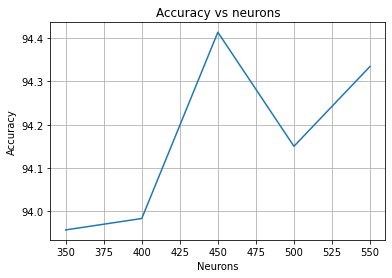

In [37]:
accu_list_3
plt.plot(range(350,600,50), accu_list_3)
plt.title('Accuracy vs neurons')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.grid(True)

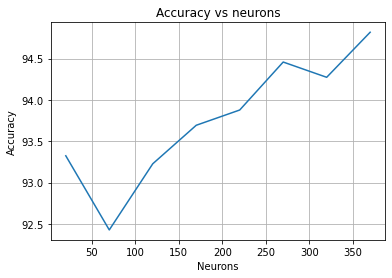

In [31]:
plt.plot(range(20,420,50), accu_list_3)
plt.title('Accuracy vs neurons')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.grid(True)

The mean square error of reconstruction is 0.0003978489257860929


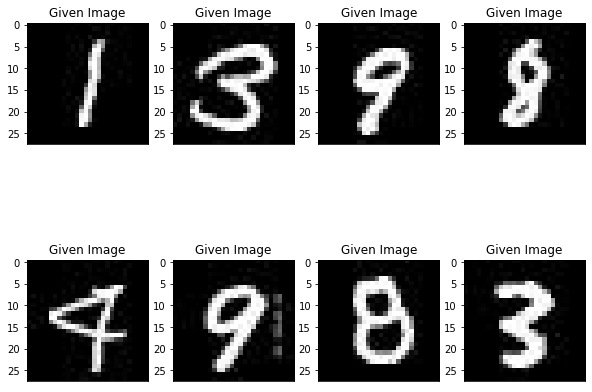

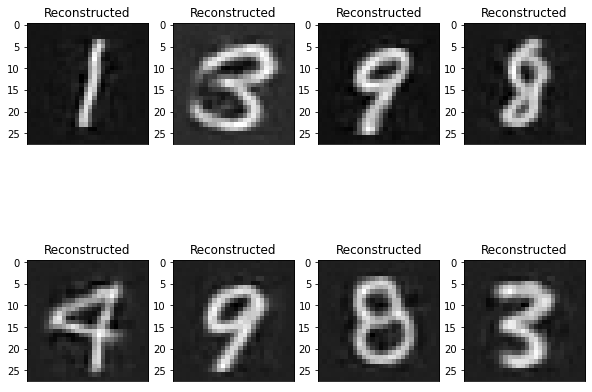

The mean square error of reconstruction is 0.0004384228668641299


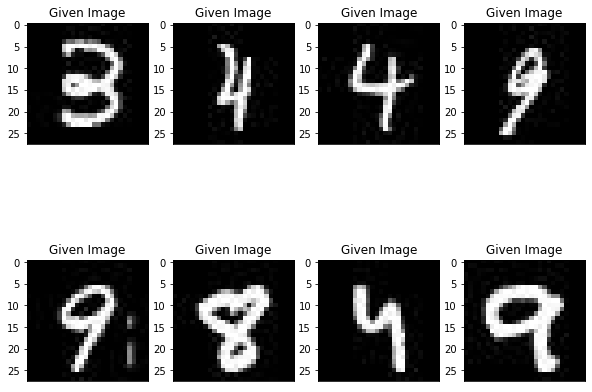

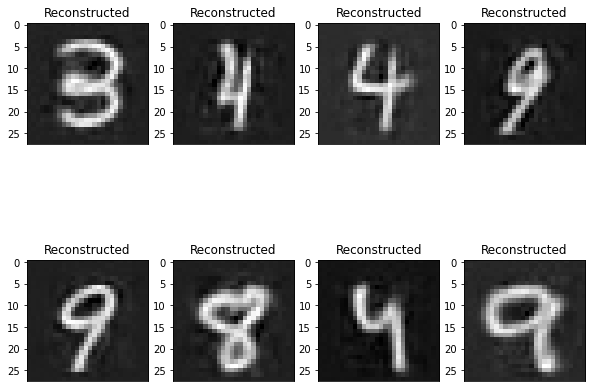

In [32]:
loss_fn = nn.MSELoss()
Y,pred_y=reconst(train_dataloader,adam_model_3l,loss_fn,"reconstruction",denoise=False)
Y,pred_y=reconst(val_dataloader,adam_model_3l,loss_fn,"reconstruction",denoise=False)

The mean square error of reconstruction is 0.0005419236840680242


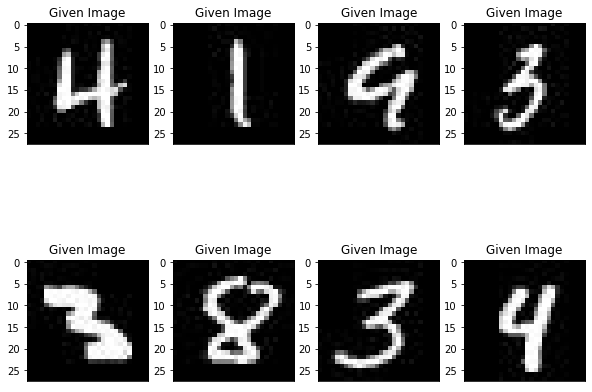

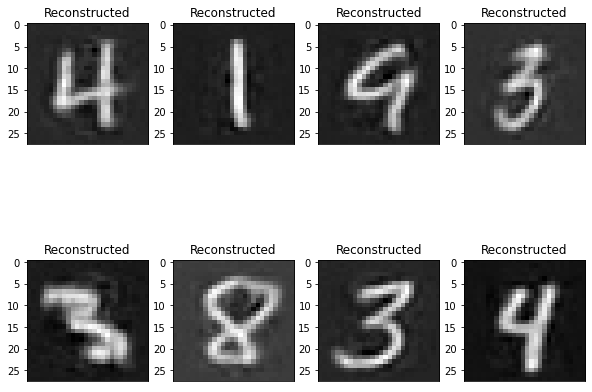

In [38]:
Y,pred_y=reconst(val_dataloader,adam_model_3l,loss_fn,"reconstruction",denoise=False)

Epochs 1
The mean square error of training is 0.19309
The mean square error of validation is 0.10626
diff= 0.19309169054031372
Epochs 2
The mean square error of training is 0.10588
The mean square error of validation is 0.07666
diff= 0.08720920979976654
Epochs 3
The mean square error of training is 0.07623
The mean square error of validation is 0.07465
diff= 0.02965402603149414
Epochs 4
The mean square error of training is 0.07414
The mean square error of validation is 0.07772
diff= 0.002091608941555023
Epochs 5
The mean square error of training is 0.07720
The mean square error of validation is 0.07719
diff= 0.0030653178691864014
Epochs 6
The mean square error of training is 0.07666
The mean square error of validation is 0.07394
diff= 0.0005379617214202881
Epochs 7
The mean square error of training is 0.07341
The mean square error of validation is 0.07056
diff= 0.003251984715461731
Epochs 8
The mean square error of training is 0.06995
The mean square error of validation is 0.06798
diff

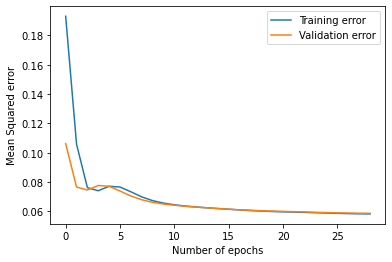

Epochs 1
The accuracy of training of classifier is 0.00%
The accuracy of validation of classifier is 20.00%
diff= 100
Epochs 2
The accuracy of training of classifier is 20.00%
The accuracy of validation of classifier is 20.00%
diff= 100
Epochs 3
The accuracy of training of classifier is 20.00%
The accuracy of validation of classifier is 20.00%
diff= 100
Epochs 4
The accuracy of training of classifier is 20.00%
The accuracy of validation of classifier is 20.00%
diff= 100
Epochs 5


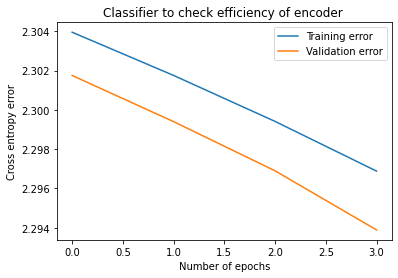

The mean square error of testing is 0.05865
The mean square error of reconstruction is 5.1175835994340165e-06


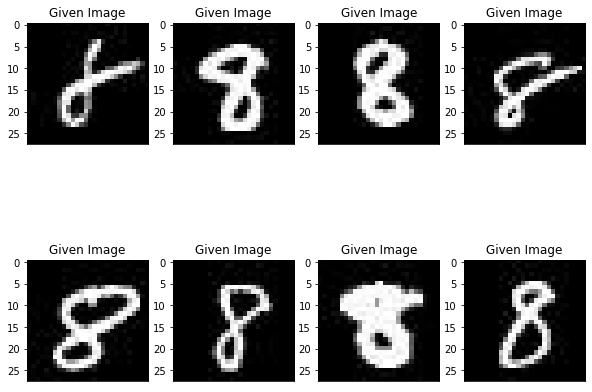

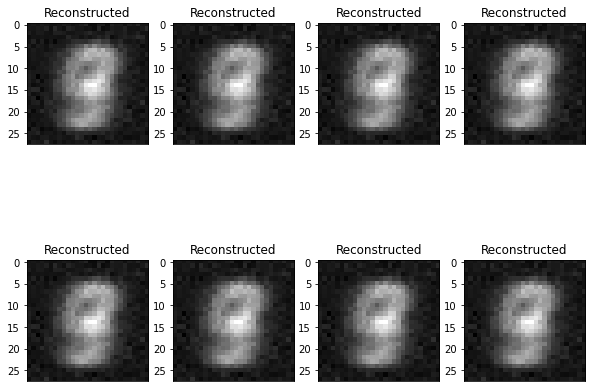

In [61]:
#Train encoder
adam_model_3l = NeuralNetwork3(450,270,450) #number of neuron for bottle neck layer 
optimizer_adam = torch.optim.Adam(adam_model_3l.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn = nn.MSELoss()

#Train type = "encoder" or "check_encoder" or "classifier"

avg_error,avg_validation,_=training(train_dataloader,adam_model_3l,loss_fn,
                                  optimizer_adam,val_dataloader,"encoder",denoise=True)
#Plot the error vs epochs
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.xlabel("Number of epochs")
plt.ylabel("Mean Squared error")
plt.legend()
plt.show()
# #Testing of encoder
# test(test_dataloader, adam_model_3l, loss_fn,"testing","encoder")

# #Run this by changing the parameters of the Neural Networks until you find the satisfaction
optimizer_adam = torch.optim.Adam(adam_model_3l.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn_classifier = nn.CrossEntropyLoss()
avg_error,avg_validation,_=training(train_dataloader,adam_model_3l,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"check_encoder",denoise=True)
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.title("Classifier to check efficiency of encoder ")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy error")
plt.legend()
plt.show()
#Testing
loss_fn = nn.MSELoss()
test(test_dataloader,adam_model_3l,loss_fn,"testing","encoder",denoise=False)
#Reconstruction

loss_fn = nn.MSELoss()
Y,pred_y=reconst(train_dataloader,adam_model_3l,loss_fn,"reconstruction",denoise=False)

The mean square error of reconstruction is 5.827207118272781% when data is denoised


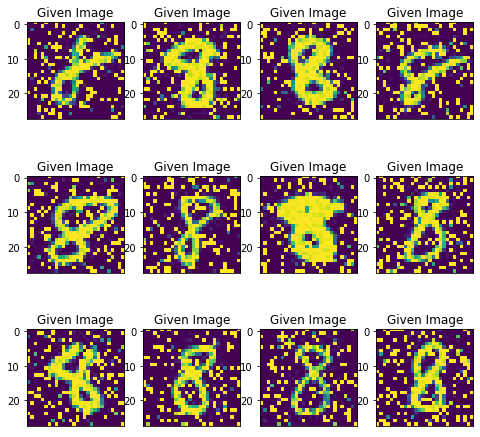

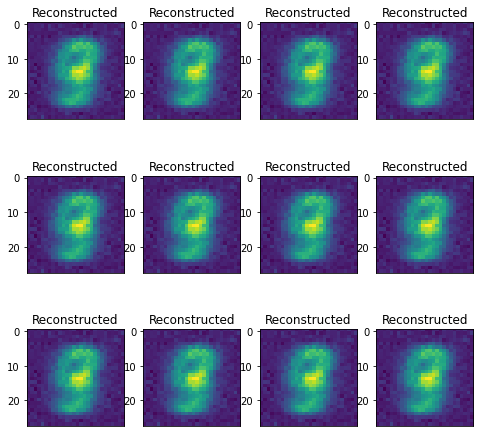

The mean square error of reconstruction is 5.1175835994340165e-06


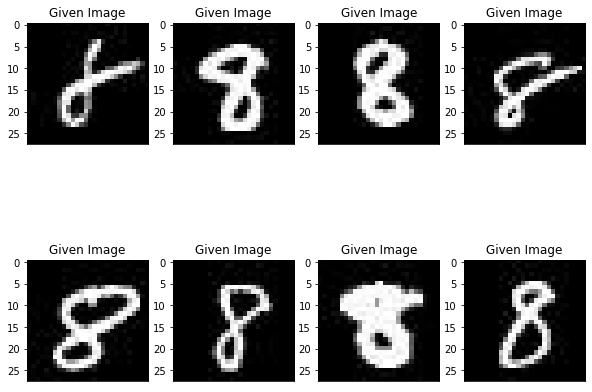

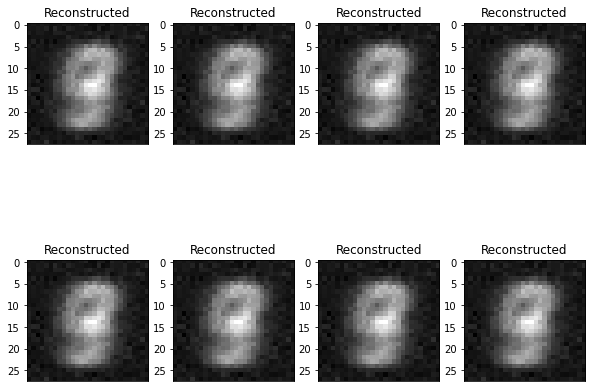

In [63]:
loss_fn = nn.MSELoss()
Y,pred_y=reconst(train_dataloader,adam_model_3l,loss_fn,"reconstruction",denoise=True)

The mean square error of reconstruction is 0.0003562347555998713


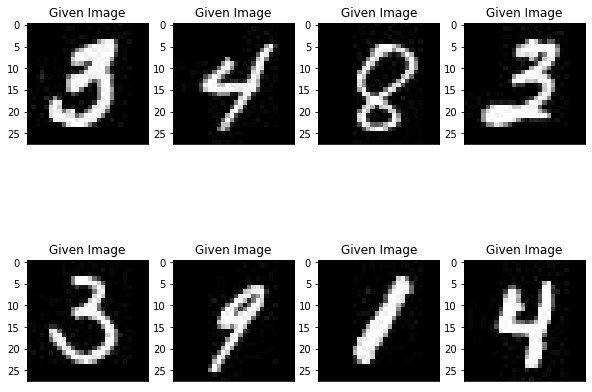

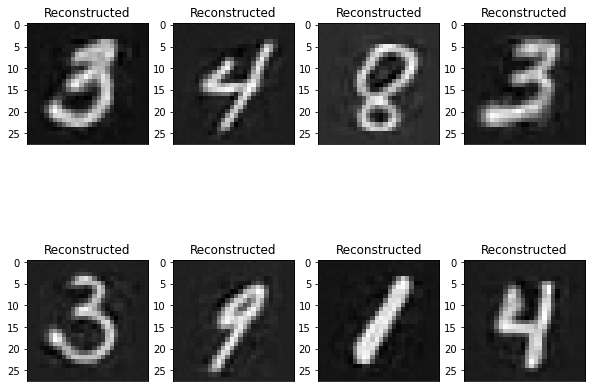

In [44]:
loss_fn = nn.MSELoss()
Y,pred_y=reconst(val_dataloader,adam_model_3l,loss_fn,"reconstruction",denoise=False)

In [ ]:
#Train encoder
adam_model_3l_2 = NeuralNetwork(80,50,80) #number of neuron for bottle neck layer 
optimizer_adam = torch.optim.Adam(adam_model_3l_2.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn = nn.MSELoss()

#Train type = "encoder" or "check_encoder" or "classifier"

avg_error,avg_validation=training(train_dataloader,adam_model_3l_2,loss_fn,
                                  optimizer_adam,val_dataloader,"encoder",denoise=False)
#Plot the error vs epochs
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.xlabel("Number of epochs")
plt.ylabel("Mean Squared error")
plt.legend()
plt.show()
# #Testing of encoder
# test(test_dataloader, adam_model_3l_2, loss_fn,"testing","encoder")

# #Run this by changing the parameters of the Neural Networks until you find the satisfaction
optimizer_adam = torch.optim.Adam(adam_model_3l_2.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
loss_fn_classifier = nn.CrossEntropyLoss()
avg_error,avg_validation=training(train_dataloader,adam_model_3l_2,loss_fn_classifier,optimizer_adam,
                                  val_dataloader,"check_encoder",denoise=False)
plt.plot(avg_error,label="Training error")
plt.plot(avg_validation,label="Validation error")
plt.title("Classifier to check efficiency of encoder ")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy error")
plt.legend()
plt.show()

The mean square error of reconstruction is 0.001081585418432951


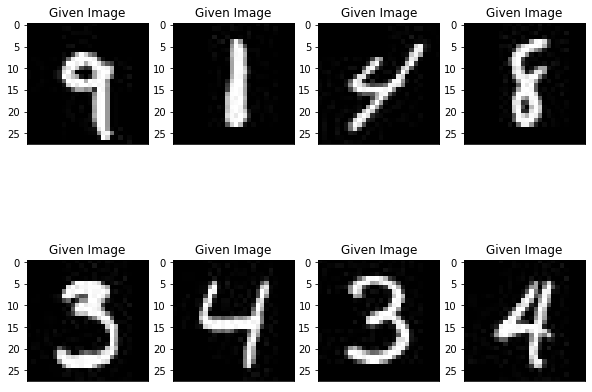

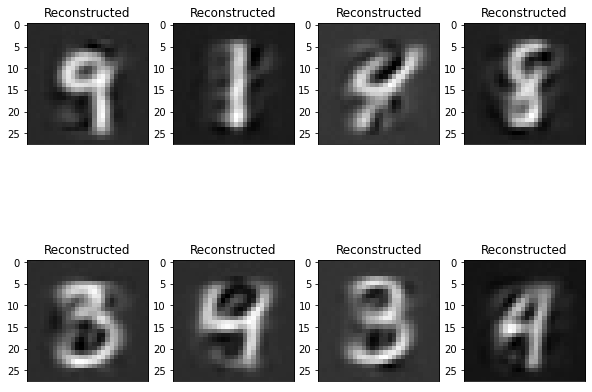

In [13]:
# #Reconstruction
loss_fn = nn.MSELoss()
Y,pred_y=reconst(train_dataloader,adam_model_3l,loss_fn,"reconstruction",denoise=False)

In [ ]:
# #Reconstruction
loss_fn = nn.MSELoss()
Y,pred_y=reconst(val_dataloader,adam_model_3l_2,loss_fn,"reconstruction",denoise=False)

In [58]:
class Classifier_3H_encoder(nn.Module):
    def __init__(self,N):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder=nn.Sequential(
        
        )
        
        self.hidden_layers = nn.Sequential(
            nn.Linear(N, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )
        
    def classify(self, X):
        X = self.flatten(X)
        self.encoder[0].weight.requires_grad=False
        self.encoder[2].weight.requires_grad=False
        encode=self.encoder(X)
        
        return self.hidden_layers(encode)
    def encode(self,X):
        X = self.flatten(X)
        return self.encoder(X)
        

Epochs 1
The accuracy of training of classifier is 77.13%
The accuracy of validation of classifier is 91.28%
diff= 1.7070396818806617
Epochs 2
The accuracy of training of classifier is 91.85%
The accuracy of validation of classifier is 91.99%
diff= 0.1601826428027635
Epochs 3
The accuracy of training of classifier is 93.32%
The accuracy of validation of classifier is 94.12%
diff= 0.017244809631551394
Epochs 4
The accuracy of training of classifier is 94.04%
The accuracy of validation of classifier is 93.47%
diff= 0.008093426569124151
Epochs 5
The accuracy of training of classifier is 94.28%
The accuracy of validation of classifier is 95.39%
diff= 0.0031135594576932046
Epochs 6
The accuracy of training of classifier is 94.83%
The accuracy of validation of classifier is 94.31%
diff= 0.004556178376915909
Epochs 7
The accuracy of training of classifier is 94.84%
The accuracy of validation of classifier is 95.39%
diff= 0.0008047973172047307
Epochs 8
The accuracy of training of classifier is

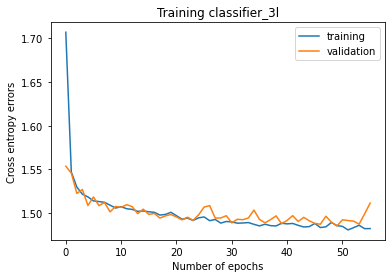

The accuracy of testing of classifier is 95.05%
CPU times: user 14min 36s, sys: 1.08 s, total: 14min 37s
Wall time: 3min 39s


1.5103443104679846

In [59]:
%%time
#classifier_3l using the encoder
#400,100,400
classifier_3l=Classifier_3H_encoder(270)
classifier_3l.add_module('encoder',adam_model_3l.encoder)


loss_fn_classifier_3l = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(classifier_3l.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)

avg_error,avg_validation,_=training(train_dataloader,classifier_3l,loss_fn_classifier_3l,optimizer_adam,
                                  val_dataloader,"classifier_3l",denoise=False)



plt.title("Training classifier_3l")
plt.plot(avg_error,label="training")
plt.plot(avg_validation,label="validation")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy errors")
plt.legend()
plt.show()

loss_fn =nn.CrossEntropyLoss()
test(test_dataloader,classifier_3l,loss_fn,"testing","classifier",denoise=False)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=len(training_data), shuffle=True)
cmat = None
for X, y in train_dataloader:
    pred = classifier_3l.classify(X)
    cmat = confusion_matrix(y, pred.argmax(dim=1))
print('Training confusion matrix:\n', cmat)

In [60]:
train_dataloader = DataLoader(training_data, batch_size=len(training_data), shuffle=False)
cmat = None
for X, y in train_dataloader:
    pred = classifier_3l.classify(X)
    cmat = confusion_matrix(y, pred.argmax(dim=1))
print('Training confusion matrix:\n', cmat)

Training confusion matrix:
 [[2205    8    7   55    2]
 [   0 2156    1   57   63]
 [   1    1 2004   44  227]
 [   1    9    3 2258    6]
 [   0    7   15   22 2233]]
